In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML


In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [4]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [5]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down3)
        up3 = self.up2(cemb2*up2 + temb2, down2)
        up4 = self.up3(cemb3*up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [6]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [50]:
timesteps = 500
beta1 = 1e-4
beta2 = 0.02


device="cuda" if torch.cuda.is_available() else "gpu"
n_feat = 256 
n_cfeat = 10 
height = 32 
save_dir = './weights/'

batch_size = 100
n_epoch = 2000
lrate=1e-3

In [51]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.9685760000000001

In [52]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [53]:
b_t.shape

torch.Size([501])

In [54]:
b_t

tensor([1.0000e-04, 1.3980e-04, 1.7960e-04, 2.1940e-04, 2.5920e-04, 2.9900e-04,
        3.3880e-04, 3.7860e-04, 4.1840e-04, 4.5820e-04, 4.9800e-04, 5.3780e-04,
        5.7760e-04, 6.1740e-04, 6.5720e-04, 6.9700e-04, 7.3680e-04, 7.7660e-04,
        8.1640e-04, 8.5620e-04, 8.9600e-04, 9.3580e-04, 9.7560e-04, 1.0154e-03,
        1.0552e-03, 1.0950e-03, 1.1348e-03, 1.1746e-03, 1.2144e-03, 1.2542e-03,
        1.2940e-03, 1.3338e-03, 1.3736e-03, 1.4134e-03, 1.4532e-03, 1.4930e-03,
        1.5328e-03, 1.5726e-03, 1.6124e-03, 1.6522e-03, 1.6920e-03, 1.7318e-03,
        1.7716e-03, 1.8114e-03, 1.8512e-03, 1.8910e-03, 1.9308e-03, 1.9706e-03,
        2.0104e-03, 2.0502e-03, 2.0900e-03, 2.1298e-03, 2.1696e-03, 2.2094e-03,
        2.2492e-03, 2.2890e-03, 2.3288e-03, 2.3686e-03, 2.4084e-03, 2.4482e-03,
        2.4880e-03, 2.5278e-03, 2.5676e-03, 2.6074e-03, 2.6472e-03, 2.6870e-03,
        2.7268e-03, 2.7666e-03, 2.8064e-03, 2.8462e-03, 2.8860e-03, 2.9258e-03,
        2.9656e-03, 3.0054e-03, 3.0452e-

In [55]:
s=0.008
f = (torch.cos((torch.linspace(0, 1, timesteps+50 + 1)+s)/(1+s) * 3.14159/2))**2
#f = (torch.cos(torch.linspace(0, 1, timesteps + 1) * 3.14159/2))**2
ab_t = f/(torch.cos((s)/(1+s) * torch.asin(torch.tensor(1))))**2
b_t = [4e-5]
k=0
ab_t = ab_t[:timesteps+1]
for i in range(1, timesteps+1):
    if(1-ab_t[i]/ab_t[i-1]<0.99 and 1-ab_t[i]/ab_t[i-1]>0.001):
        b_t.append(1-ab_t[i]/ab_t[i-1])
    elif(1-ab_t[i]/ab_t[i-1]>=0.99):
        b_t.append(0.99)
    elif(1-ab_t[i]/ab_t[i-1]<=0.001):
        b_t.append(0.001+k*0.00001)
        k+=1
b_t = torch.tensor(b_t)
a_t = 1 - b_t
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [15]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

8.192e-06

In [46]:
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.SGD(nn_model.parameters(), lr=lrate)

In [47]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.9685760000000001

In [48]:
nn_model

ContextUnet(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(25

In [49]:
from torchvision.datasets import MNIST, CIFAR10
tf = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

Files already downloaded and verified


In [20]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.191468032

In [21]:
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [22]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [23]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [24]:
# define sampling function for DDIM
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [25]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, context, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [26]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [27]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

In [28]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.191468032

In [35]:
checkpoint = torch.load(f"{save_dir}nn_model1990.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])




<All keys matched successfully>

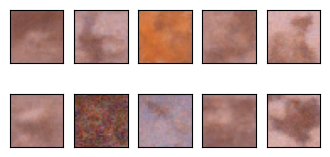

In [41]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

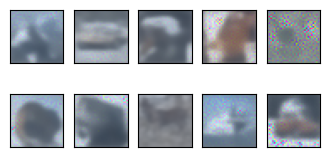

In [34]:
# user defined context
ctx = torch.tensor([
    
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [884]:
samples.dtype

torch.float32

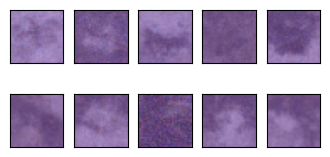

In [795]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]

tensor([0, 3, 4, 6, 5, 8, 9, 8, 5, 7, 3, 9, 7, 7, 3, 9, 6, 4, 5, 3, 0, 8, 2, 8,
        4, 0, 0, 0, 1, 2, 9, 8, 8, 0, 6, 8, 5, 5, 2, 0, 4, 1, 5, 6, 6, 7, 6, 0,
        4, 4, 2, 4, 1, 1, 7, 6, 2, 2, 7, 4, 6, 9, 0, 7, 7, 8, 1, 5, 8, 9, 4, 6,
        2, 6, 5, 6, 7, 4, 0, 7, 7, 4, 8, 7, 4, 8, 3, 2, 6, 1, 1, 5, 8, 3, 4, 5,
        6, 1, 4, 6])
(3, 32, 32)


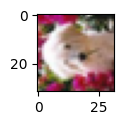

In [914]:
b = None
pbar = tqdm(dataloader, mininterval = 2)
for x, c in pbar:
    print(c)
    k=0
    for i in range(0,100):
        if(c[i]==5):
            k=i
    b = np.array(x[k])
    print(b.shape)
    plt.figure(figsize = (20,1))
    plt.imshow(b.T)
    break

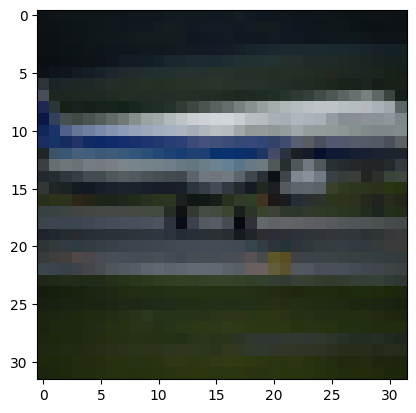

In [834]:
plt.imshow(np.transpose(b, (1,2,0)))

In [855]:
from PIL import Image

from numpy import asarray

# load the image

image = Image.open('/home/rounak/Downloads/tryptag.jpg')

# convert image to numpy array

data = asarray(image)

print(type(data))

<class 'numpy.ndarray'>


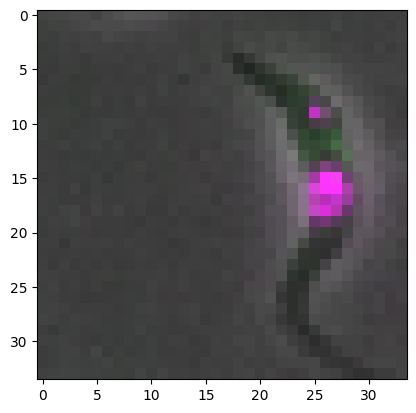

In [869]:
i = 6
plt.imshow(data[2880:3840][580:780, 430:630][::i,::i])

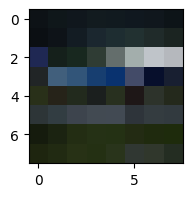

In [840]:
plt.imshow(B[::4,::4,:])
plt.gcf().set_size_inches(2,2)

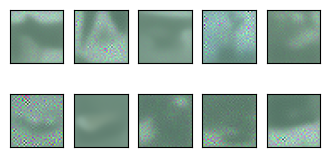

In [810]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [448]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

SyntaxError: incomplete input (2988299999.py, line 2)

In [ ]:
# user defined context
ctx = torch.tensor([
    
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())